In [1]:
import importlib
import sys

sys.path.append("..")  # Ensure the parent directory is in the path

from dataclasses import dataclass
from data_preprocessing.dataset_dataloader import create_data_loader
from transformers import AutoTokenizer
from tqdm import tqdm

# --- Local Application/Module Imports ---
import data_loader.data_loader
import data_preprocessing.data_preprocessing
import data_preprocessing.llm_augmentation
import models.models
import visualizations.visualizations
import utils.utils

importlib.reload(data_loader.data_loader)
from data_loader.data_loader import *

importlib.reload(data_preprocessing.data_preprocessing)

importlib.reload(data_preprocessing.llm_augmentation)
from data_preprocessing.llm_augmentation import *

importlib.reload(models.models)
from models.models import *

importlib.reload(visualizations.visualizations)
from visualizations.visualizations import *

importlib.reload(utils.utils)
from utils.utils import *

# --- Notebook Configuration ---
%matplotlib inline
%config InlineBackend.figure_format='retina'

# --- Global Settings ---
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tnorlha/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/tnorlha/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /Users/tnorlha/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/tnorlha/nltk_data...
[nltk_data]   Package wordnet is alre

## Loading data and splitting into train, validation, and test sets

In [4]:
train_df, val_df, test_df = load_and_split_data()

print("Train size:", len(train_df))
print("Validation size:", len(val_df))
print("Test size:", len(test_df))

Train size: 81677
Validation size: 10210
Test size: 10210


In [5]:
device = get_device()
print(f"Using device: {device}")

Using device: mps


----

In [9]:
@dataclass
class Config:
    batch_size: int
    model: str
    seed: int
    lr: float
    dropout: float
    attention_dropout: float
    device: str
    num_classes: int
    max_len: int

config = Config(
    batch_size = 16,
    model="FacebookAI/roberta-large",
    seed=RANDOM_SEED,
    lr=3e-5,
    dropout=0.1,
    attention_dropout=0.1,
    device=device,
    num_classes=3,
    max_len=64,
)

def load_model(config: Config, model_name, model_path, test_df):
    config.model = model_name

    llm_tokenizer = AutoTokenizer.from_pretrained(config.model)
    llm_model = load_blank_model(config)

    # Load saved model state dict
    state_dict = torch.load(model_path, map_location=device)
    llm_model.load_state_dict(state_dict)

    llm_model.to(device)
    llm_model.eval()


    loss_fn = nn.CrossEntropyLoss().to(device)
    test_data_loader = create_data_loader(test_df, llm_tokenizer, config.max_len, config.batch_size)

    return llm_model, loss_fn, test_data_loader

### distilbert-base-cased

In [51]:
model_name = "distilbert/distilbert-base-cased"
model_path = "distilbert-base-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
y_review_texts, y_pred_dbc, y_pred_probs_dbc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [53]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dbc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dbc))

              precision    recall  f1-score   support

    negative       0.68      0.64      0.66      2191
     neutral       0.77      0.80      0.79      4915
    positive       0.73      0.73      0.73      3104

    accuracy                           0.74     10210
   macro avg       0.73      0.72      0.73     10210
weighted avg       0.74      0.74      0.74     10210

L-score is:  0.847796278158668


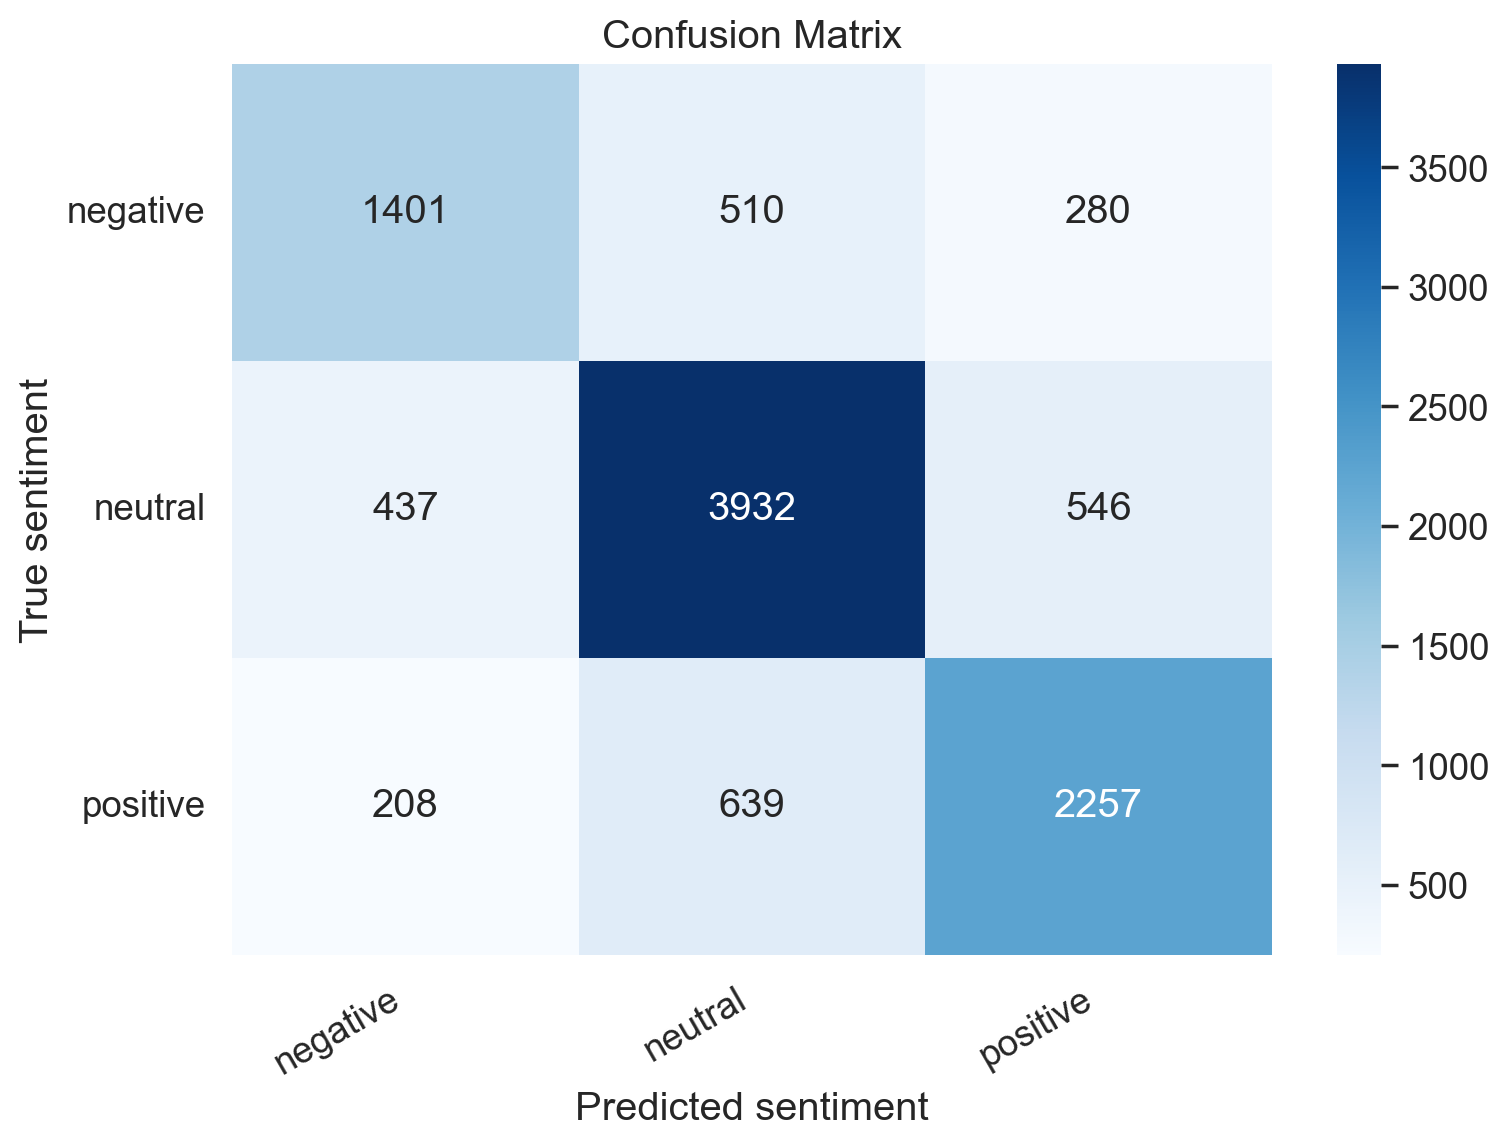

In [54]:
plot_confusion_matrix(y_test, y_pred_dbc, class_names)

### distilbert-base-multilingual-cased

In [55]:
model_name = "distilbert/distilbert-base-multilingual-cased"
model_path = "distilbert-base-multilingual-cased.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [56]:
y_review_texts, y_pred_dbmc, y_pred_probs_dbmc, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [57]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dbmc, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dbmc))

              precision    recall  f1-score   support

    negative       0.65      0.58      0.61      2191
     neutral       0.74      0.83      0.78      4915
    positive       0.74      0.65      0.69      3104

    accuracy                           0.72     10210
   macro avg       0.71      0.69      0.70     10210
weighted avg       0.72      0.72      0.72     10210

L-score is:  0.8334476003917728


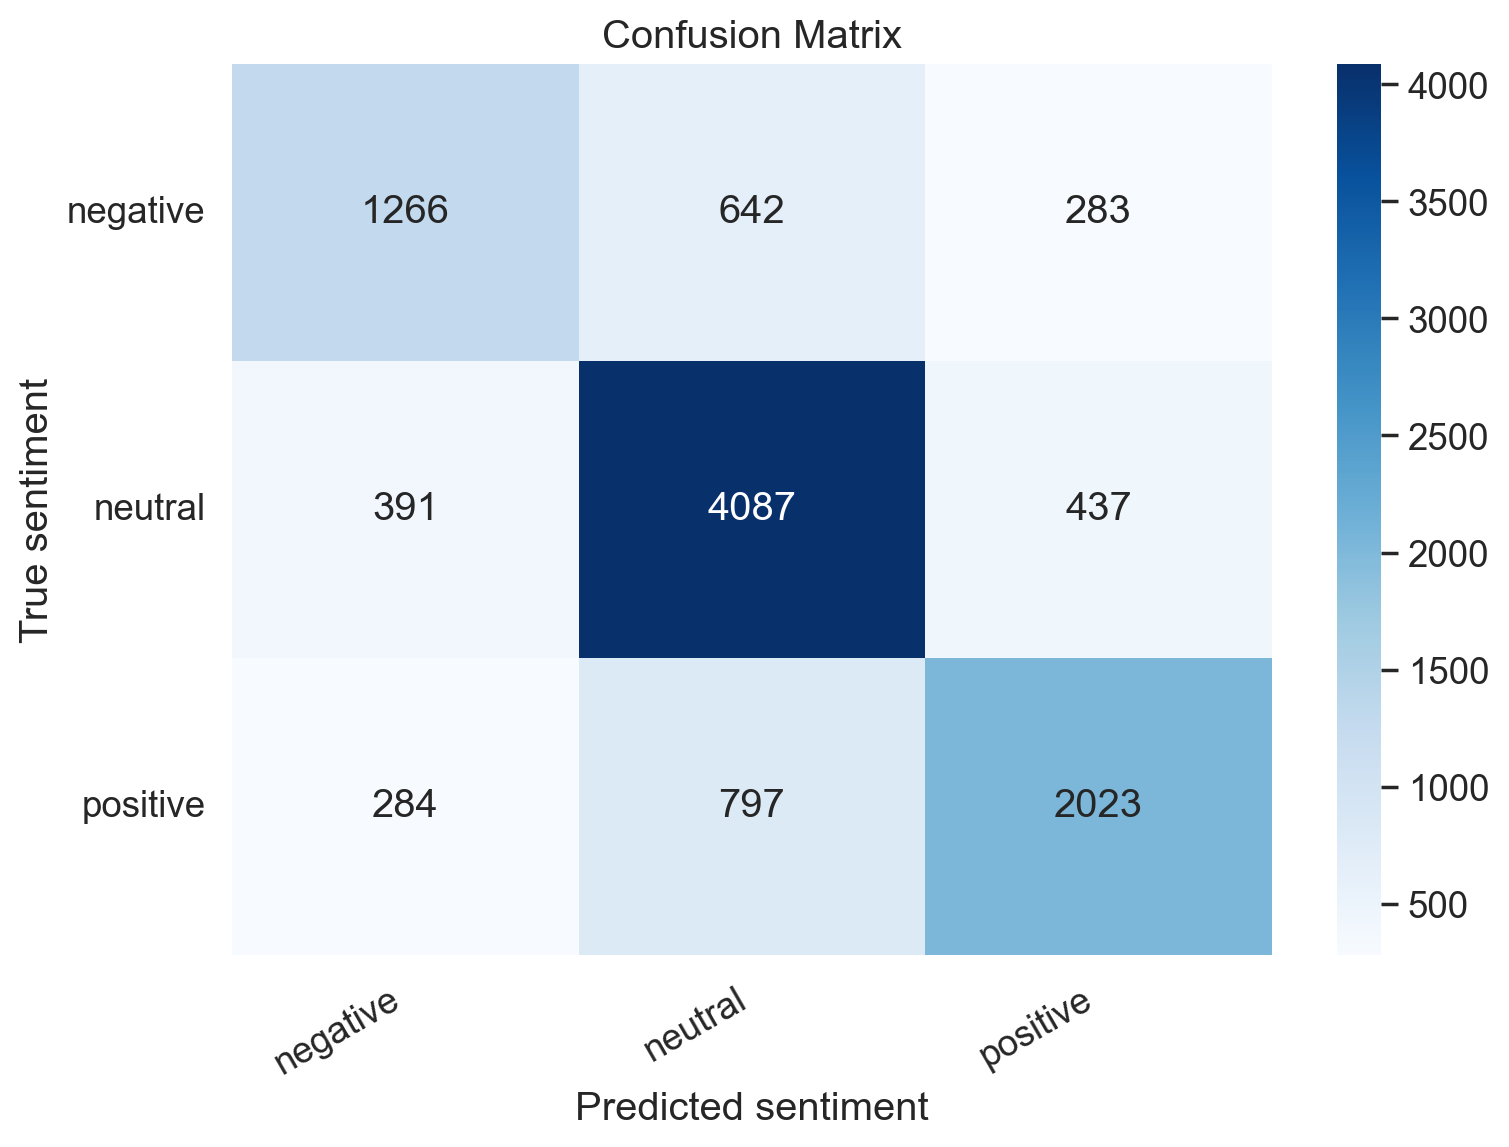

In [58]:
plot_confusion_matrix(y_test, y_pred_dbmc, class_names)

### roberta-base

In [59]:
model_name = "FacebookAI/roberta-base"
model_path = "roberta-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [60]:
y_review_texts, y_pred_rb, y_pred_probs_rb, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [61]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_rb, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_rb))

              precision    recall  f1-score   support

    negative       0.76      0.74      0.75      2191
     neutral       0.82      0.82      0.82      4915
    positive       0.79      0.79      0.79      3104

    accuracy                           0.80     10210
   macro avg       0.79      0.79      0.79     10210
weighted avg       0.80      0.80      0.80     10210

L-score is:  0.8821743388834475


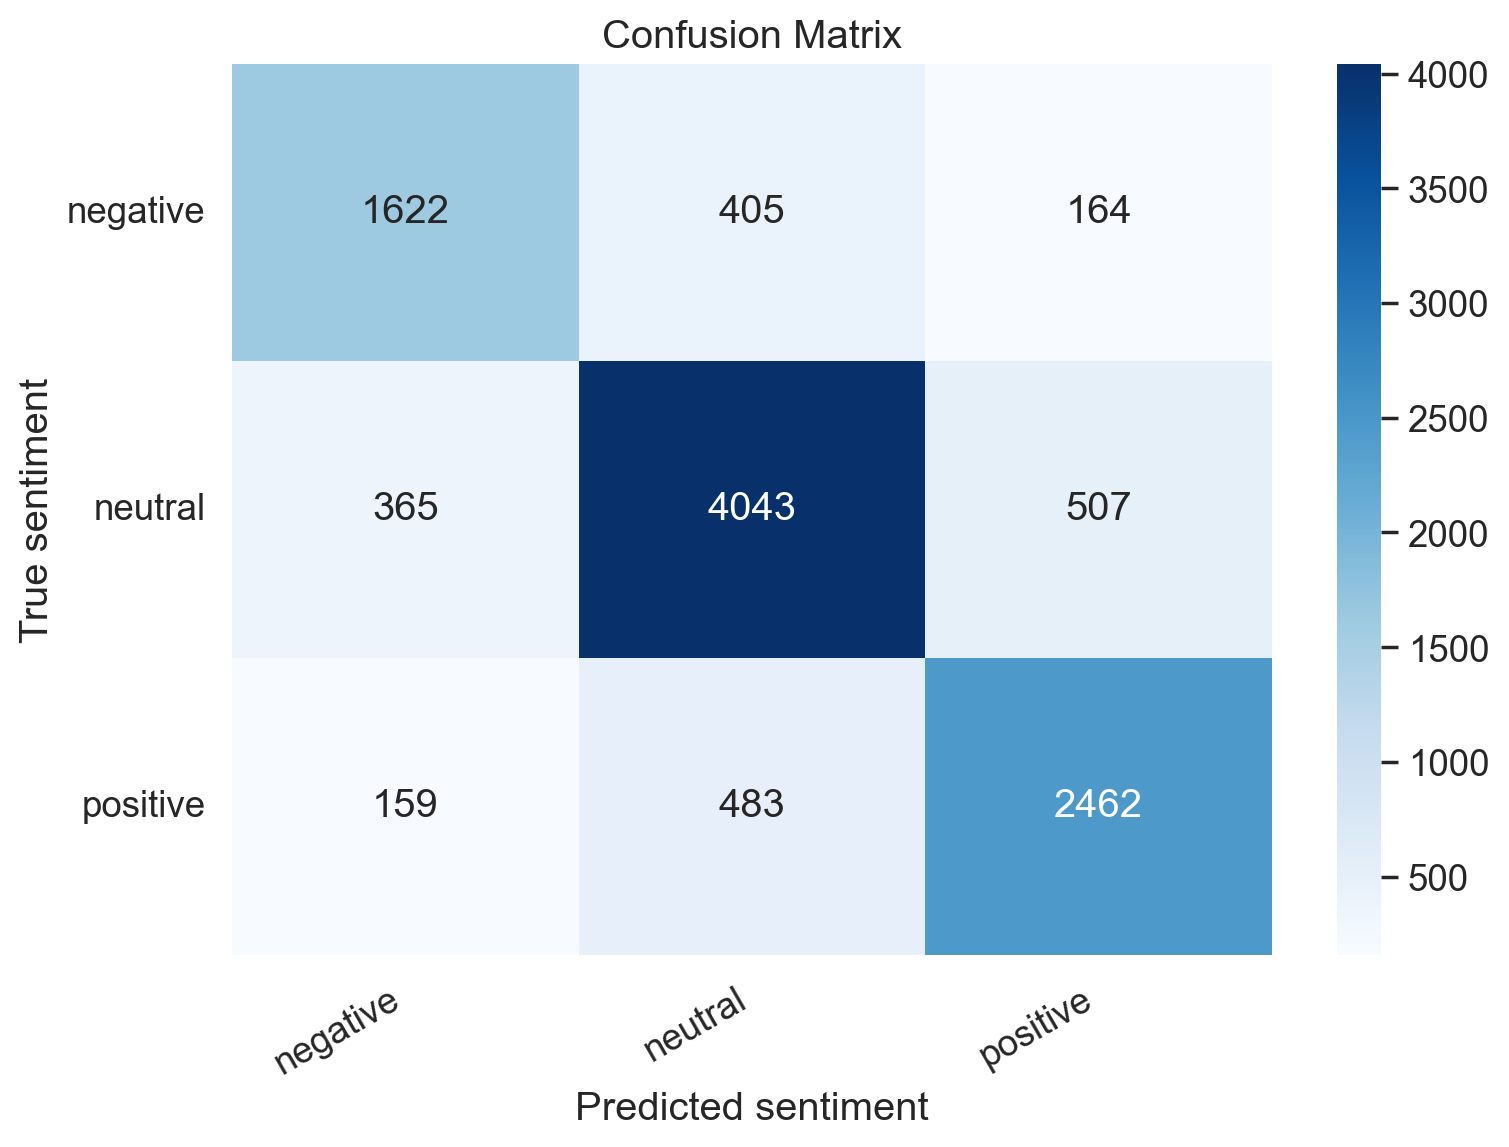

In [62]:
plot_confusion_matrix(y_test, y_pred_rb, class_names)

### xlm-roberta-base

In [63]:
model_name = "FacebookAI/xlm-roberta-base"
model_path = "xlm-roberta-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [64]:
y_review_texts, y_pred_xlmrb, y_pred_probs_xlmrb, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [65]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_xlmrb, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_xlmrb))

              precision    recall  f1-score   support

    negative       0.71      0.68      0.69      2191
     neutral       0.81      0.81      0.81      4915
    positive       0.75      0.77      0.76      3104

    accuracy                           0.77     10210
   macro avg       0.75      0.75      0.75     10210
weighted avg       0.77      0.77      0.77     10210

L-score is:  0.8612634671890304


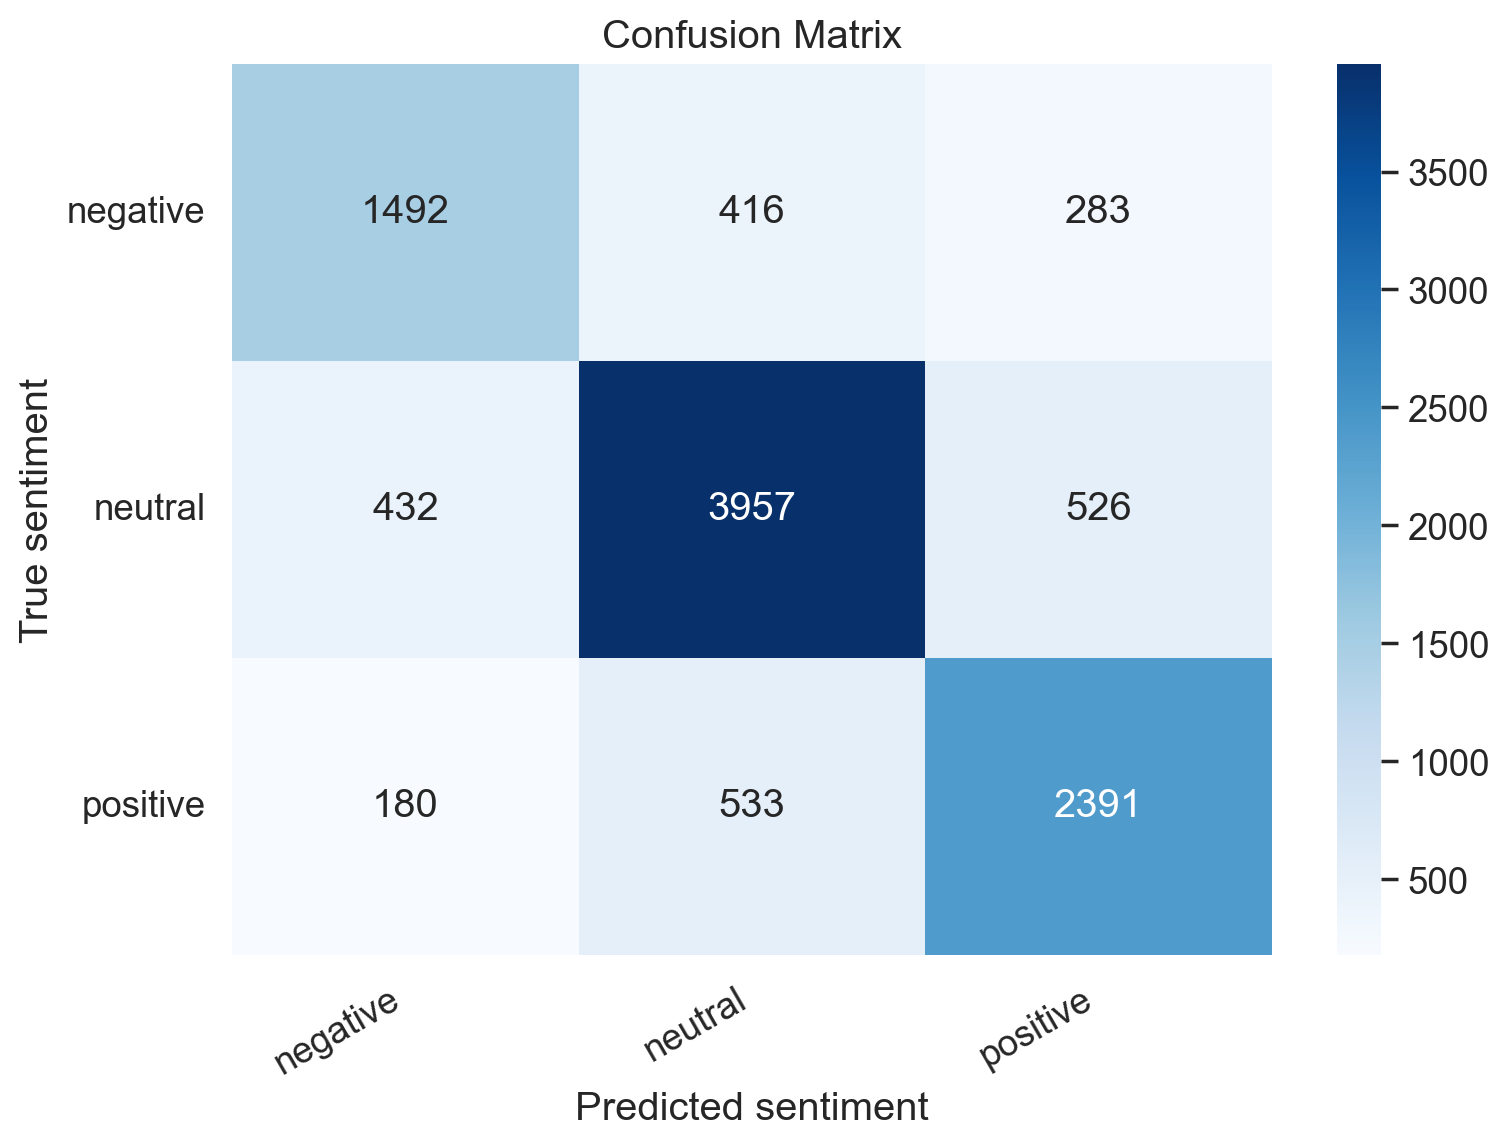

In [66]:
plot_confusion_matrix(y_test, y_pred_xlmrb, class_names)

### roberta-large

In [67]:
model_name = "FacebookAI/roberta-large"
model_path = "roberta-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [68]:
y_review_texts, y_pred_rl, y_pred_probs_rl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [69]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_rl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_rl))

              precision    recall  f1-score   support

    negative       0.77      0.74      0.76      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.79      0.81      0.80      3104

    accuracy                           0.81     10210
   macro avg       0.80      0.79      0.80     10210
weighted avg       0.81      0.81      0.81     10210

L-score is:  0.88692458374143


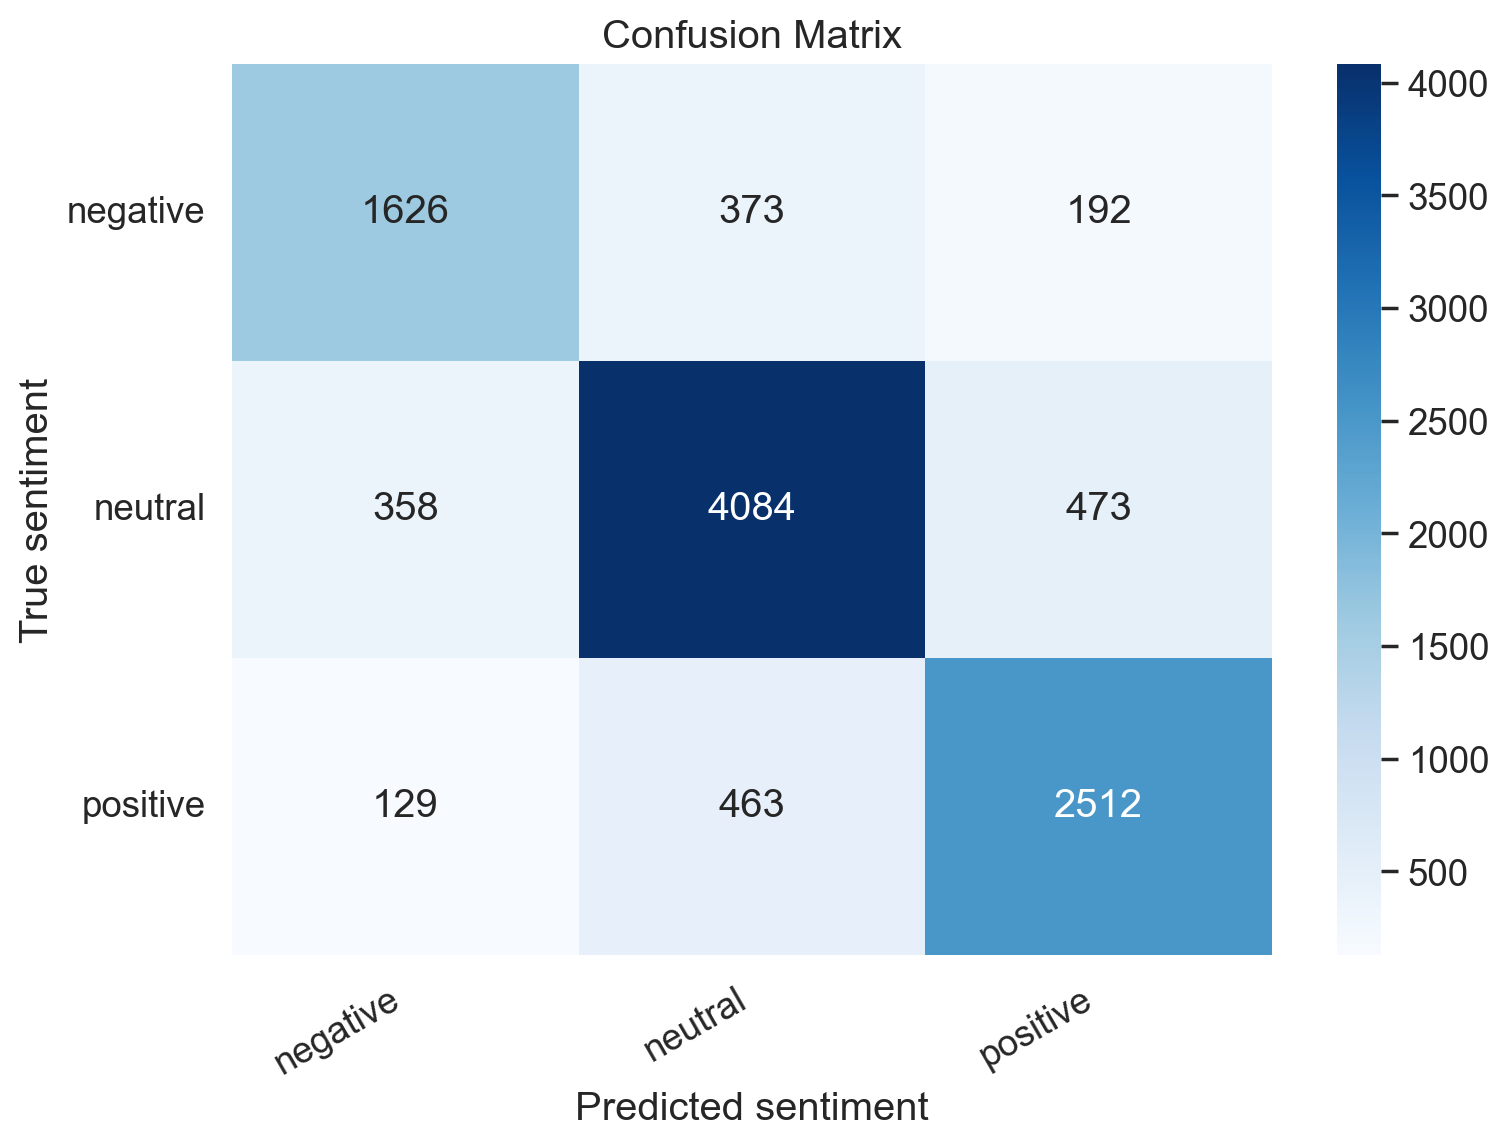

In [70]:
plot_confusion_matrix(y_test, y_pred_rl, class_names)

### xlm-roberta-large

In [71]:
model_name = "FacebookAI/xlm-roberta-large"
model_path = "xlm-roberta-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/xlm-roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [72]:
y_review_texts, y_pred_xmlrl, y_pred_probs_xmlrl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [73]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_xmlrl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_xmlrl))

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00      2191
     neutral       0.48      1.00      0.65      4915
    positive       0.00      0.00      0.00      3104

    accuracy                           0.48     10210
   macro avg       0.16      0.33      0.22     10210
weighted avg       0.23      0.48      0.31     10210

L-score is:  0.7406953966699314


/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/tnorlha/miniconda3/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


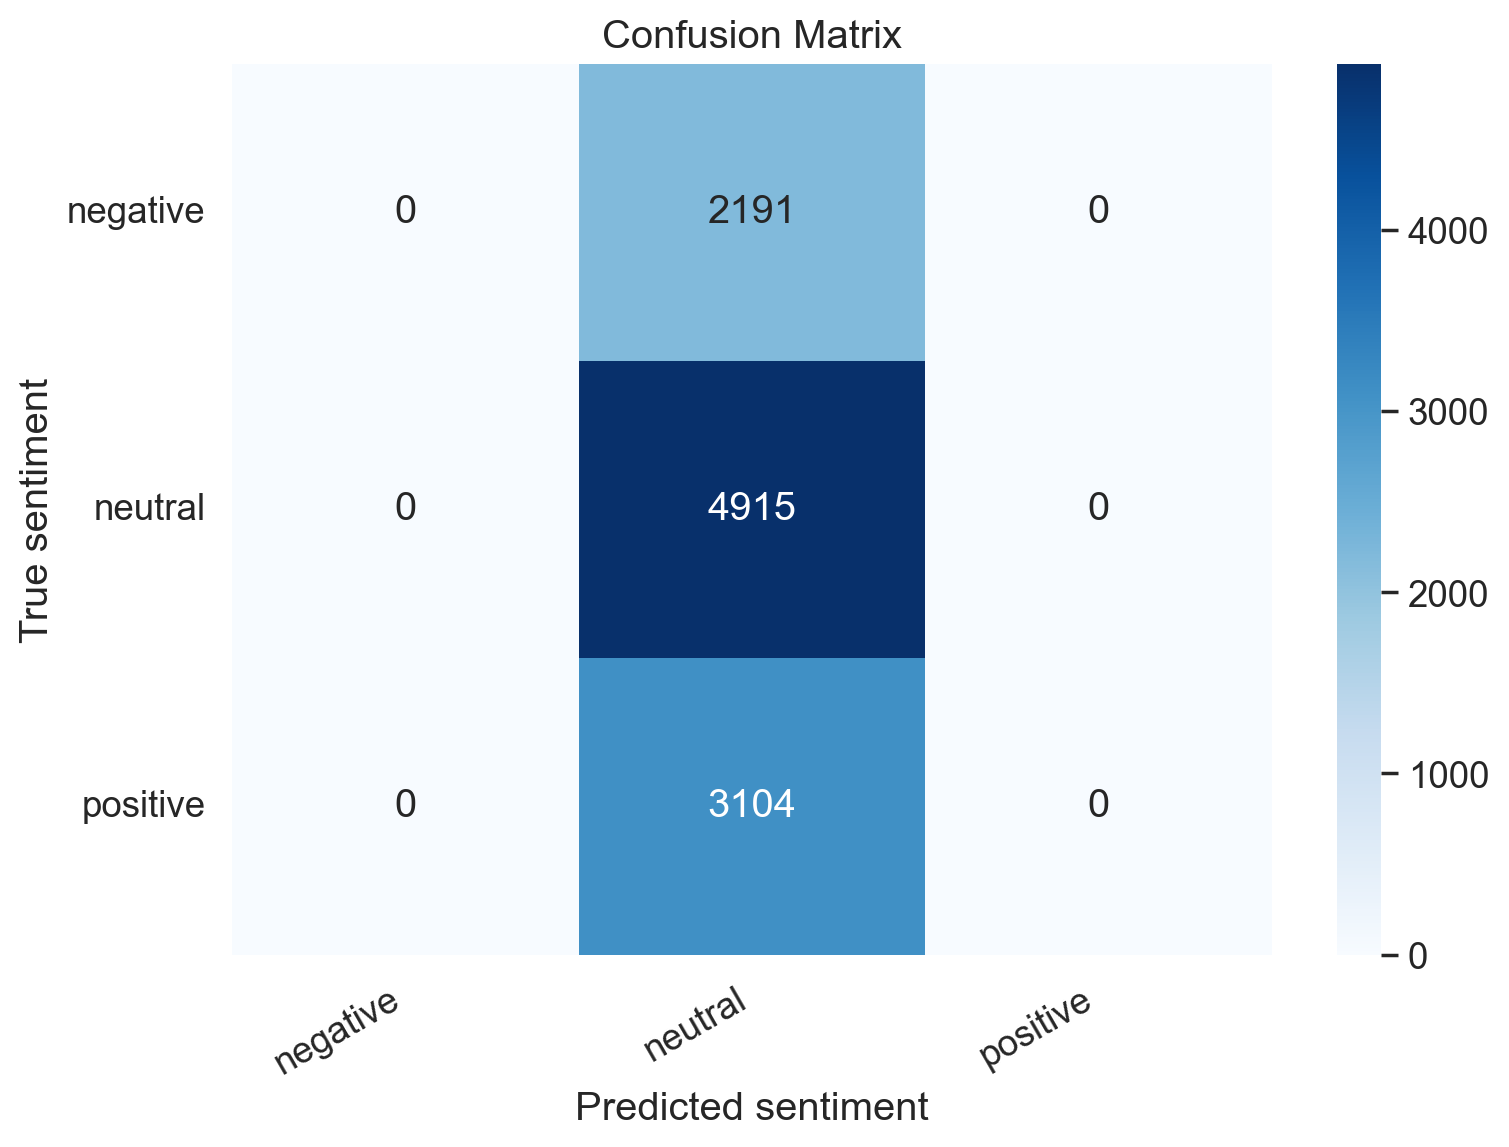

In [74]:
plot_confusion_matrix(y_test, y_pred_xmlrl, class_names)

### deberta-v3-base

In [75]:
model_name = "microsoft/deberta-v3-base"
model_path = "deberta-v3-base.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
y_review_texts, y_pred_db, y_pred_probs_db, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [77]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_db, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_db))

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      2191
     neutral       0.83      0.83      0.83      4915
    positive       0.80      0.81      0.81      3104

    accuracy                           0.81     10210
   macro avg       0.81      0.81      0.81     10210
weighted avg       0.81      0.81      0.81     10210

L-score is:  0.8938295788442703


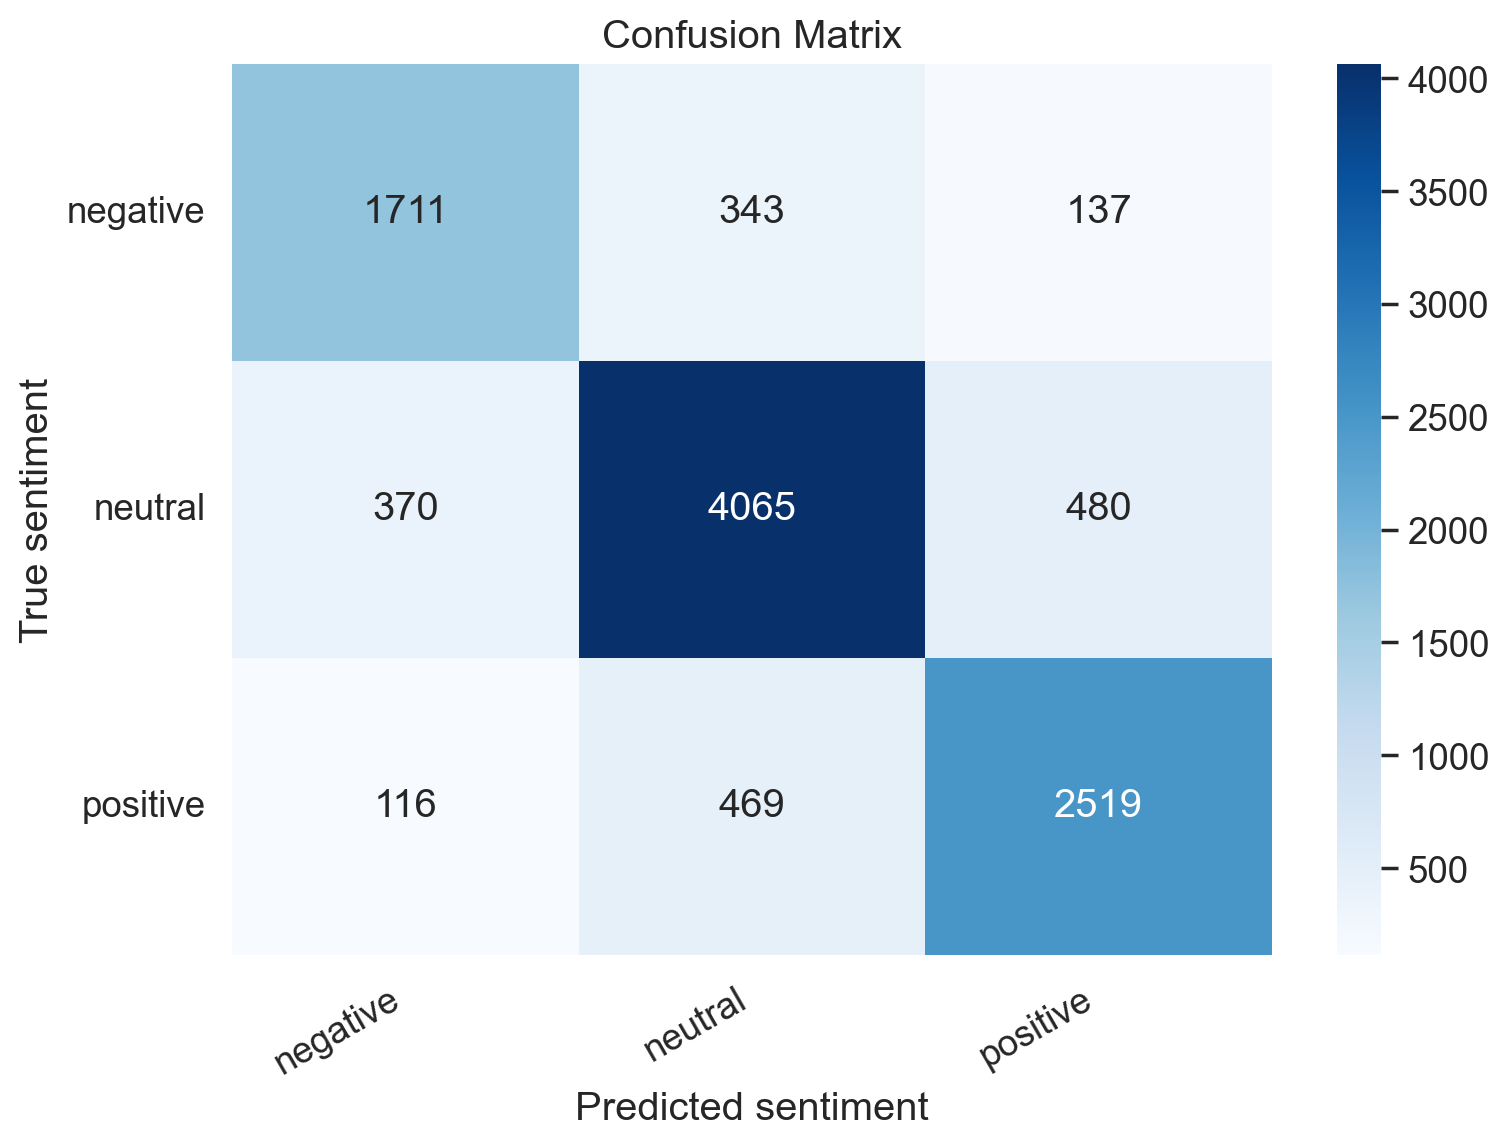

In [78]:
plot_confusion_matrix(y_test, y_pred_db, class_names)

### deberta-v3-large

In [79]:
model_name = "microsoft/deberta-v3-large"
model_path = "deberta-v3-large.bin"

llm_model, loss_fn, test_data_loader = load_model(config, model_name, model_path, test_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(
Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-large and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [80]:
y_review_texts, y_pred_dl, y_pred_probs_dl, y_test = get_predictions(
    llm_model,
    test_data_loader,
    device
)

In [81]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, y_pred_dl, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, y_pred_dl))

              precision    recall  f1-score   support

    negative       0.78      0.78      0.78      2191
     neutral       0.83      0.84      0.83      4915
    positive       0.82      0.81      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.81      0.81      0.81     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.8974534769833497


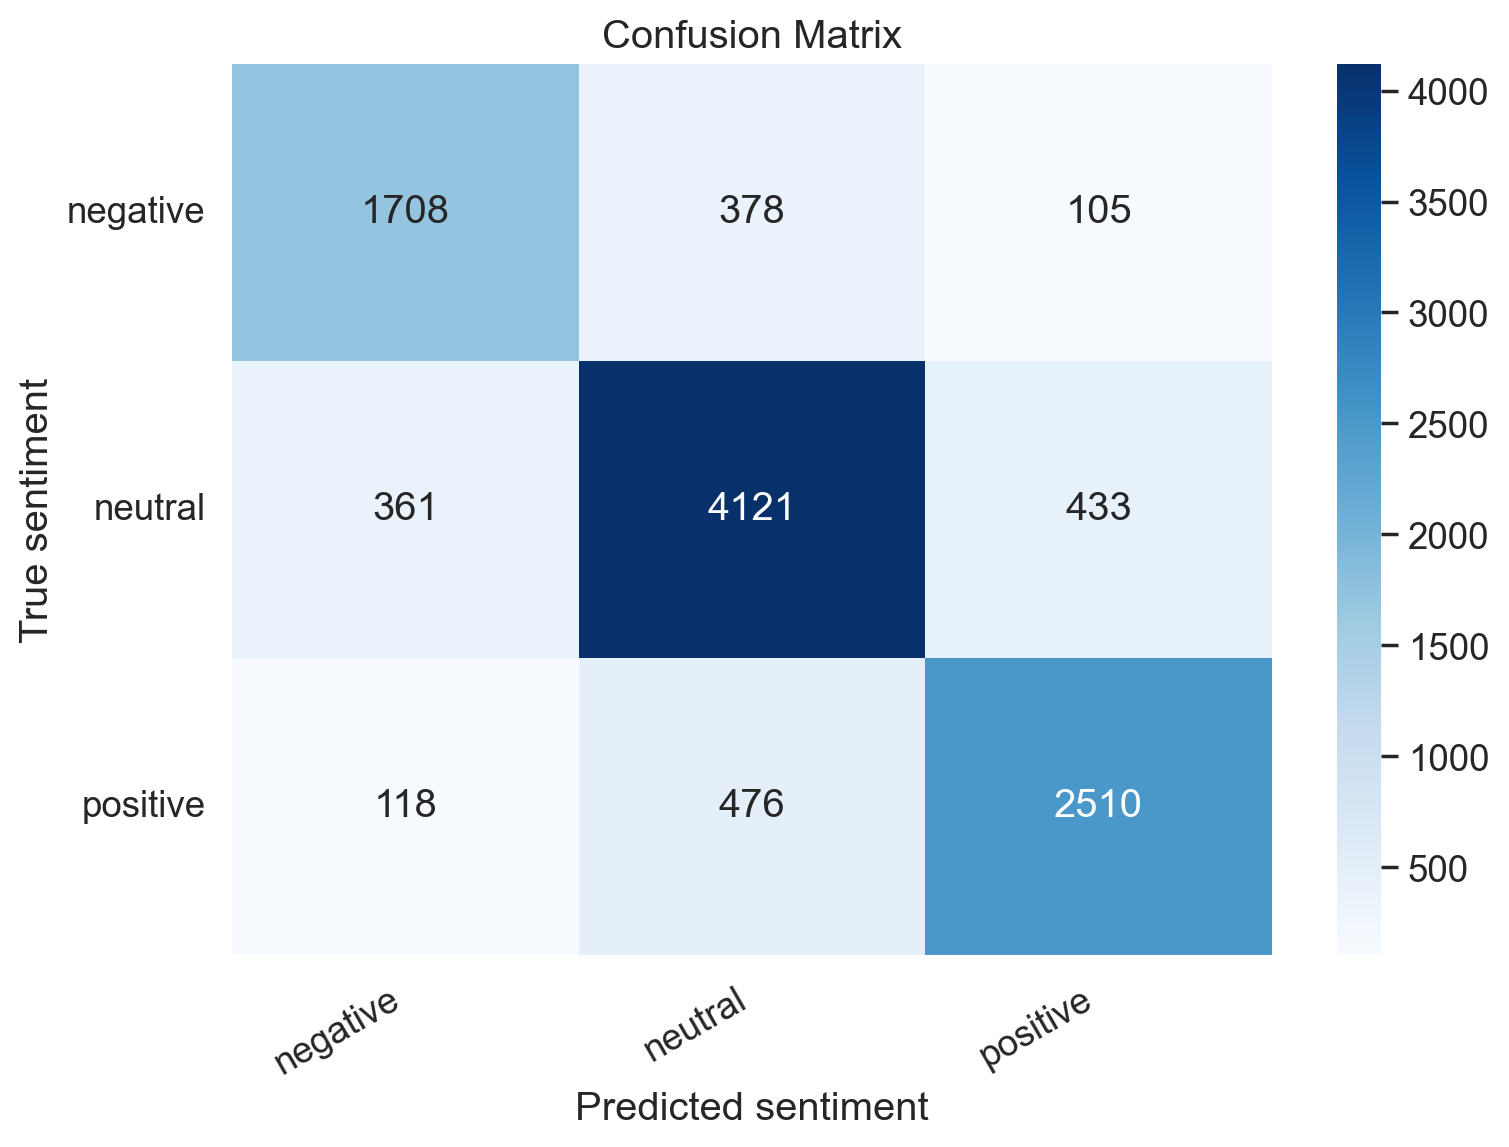

In [82]:
plot_confusion_matrix(y_test, y_pred_dl, class_names)

## Majority voting

In [83]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db],
    strategy="majority"
)

In [84]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_majority, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_majority))

              precision    recall  f1-score   support

    negative       0.79      0.78      0.79      2191
     neutral       0.84      0.85      0.84      4915
    positive       0.82      0.82      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.9010284035259549


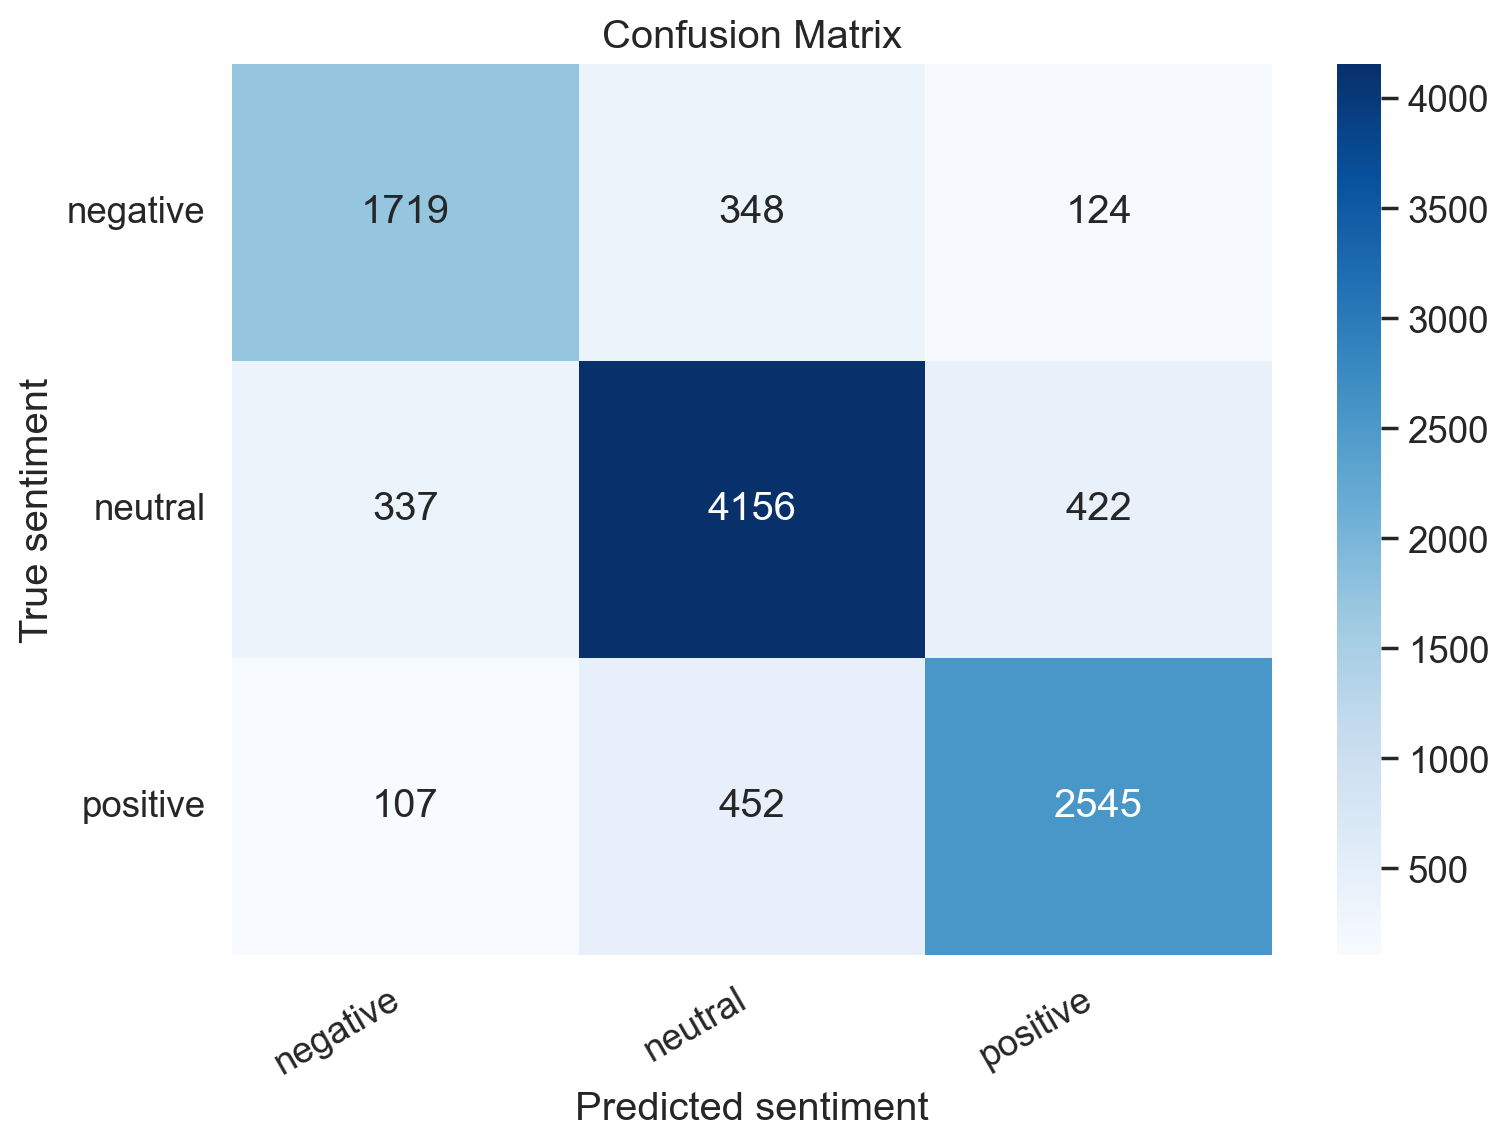

In [85]:
plot_confusion_matrix(y_test, final_preds_majority, class_names)

## Softmax average

In [86]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db],
    strategy="softmax_avg"
)

In [87]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.84      4915
    positive       0.82      0.82      0.82      3104

    accuracy                           0.83     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.83      0.83      0.83     10210

L-score is:  0.9019588638589618


In [ ]:
# test out

In [112]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [113]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.78      0.79      2191
     neutral       0.84      0.85      0.85      4915
    positive       0.83      0.82      0.83      3104

    accuracy                           0.83     10210
   macro avg       0.82      0.82      0.82     10210
weighted avg       0.83      0.83      0.83     10210

L-score is:  0.9033790401567091


In [103]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_xlmrb, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_xlmrb, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [104]:
class_names = ['negative', 'neutral', 'positive']
print(classification_report(y_test, final_preds_softmax_avg, labels=[0, 1, 2], target_names=class_names))

print("L-score is: ", L_score(y_test, final_preds_softmax_avg))

              precision    recall  f1-score   support

    negative       0.80      0.77      0.78      2191
     neutral       0.83      0.86      0.85      4915
    positive       0.83      0.81      0.82      3104

    accuracy                           0.82     10210
   macro avg       0.82      0.81      0.82     10210
weighted avg       0.82      0.82      0.82     10210

L-score is:  0.9004407443682664


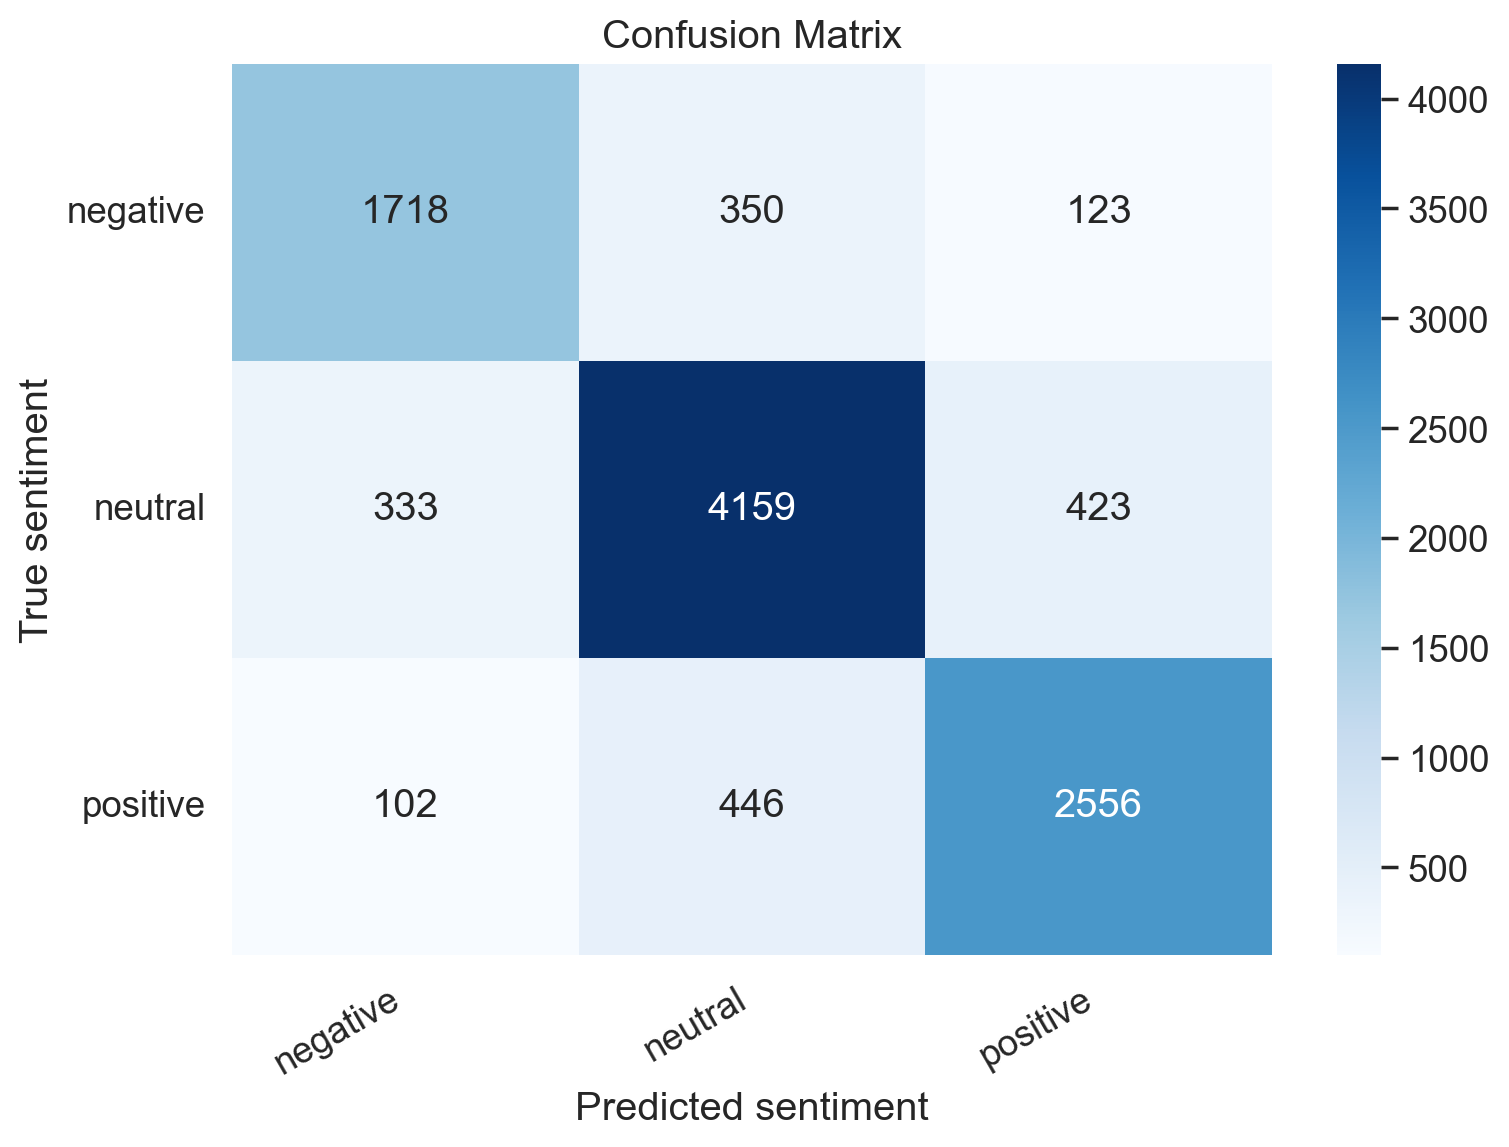

In [88]:
plot_confusion_matrix(y_test, final_preds_softmax_avg, class_names)

## Submission

In [114]:
submission_df = load_submission_data()

def create_submission_data_loader_with_model(model_name, config, submission_df):
    llm_tokenizer = AutoTokenizer.from_pretrained(model_name)
    submission_data_loader = create_data_loader(submission_df, llm_tokenizer, config.max_len, config.batch_size)

    return submission_data_loader, llm_tokenizer

distilbert/distilbert-base-multilingual-cased

In [115]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("distilbert/distilbert-base-multilingual-cased", config, submission_df)

In [116]:
y_review_texts, y_pred_dbmc, y_pred_probs_dbmc, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

deberta-v3-base

In [117]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("microsoft/deberta-v3-base", config, submission_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [118]:
y_review_texts, y_pred_db, y_pred_probs_db, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

deberta-v3-large

In [119]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("microsoft/deberta-v3-large", config, submission_df)

/Users/tnorlha/miniconda3/lib/python3.12/site-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


In [120]:
y_review_texts, y_pred_dl, y_pred_probs_dl, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

roberta-large

In [121]:
submission_data_loader, llm_tokenizer = create_submission_data_loader_with_model("FacebookAI/roberta-large", config, submission_df)

In [122]:
y_review_texts, y_pred_rl, y_pred_probs_rl, y_test = get_predictions(
    llm_model,
    submission_data_loader,
    device
)

### Majority voting submission

In [123]:
final_preds_majority = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    strategy="majority"
)

In [124]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(final_preds_majority, label_map=label_map, output_path="../submissions/majority_voting_submission.csv")

Submission file saved to ../submissions/majority_voting_submission.csv


In [125]:
final_preds_softmax_avg = predict_with_ensemble(
    preds_list=[y_pred_dl, y_pred_rl, y_pred_db, y_pred_dbmc],
    probs_list=[y_pred_probs_dl, y_pred_probs_rl, y_pred_probs_db, y_pred_probs_dbmc],
    strategy="softmax_avg"
)

In [126]:
label_map = {0: "negative", 1: "neutral", 2: "positive"}
generate_submission(final_preds_majority, label_map=label_map, output_path="../submissions/softmax_avg.csv")

Submission file saved to ../submissions/softmax_avg.csv
